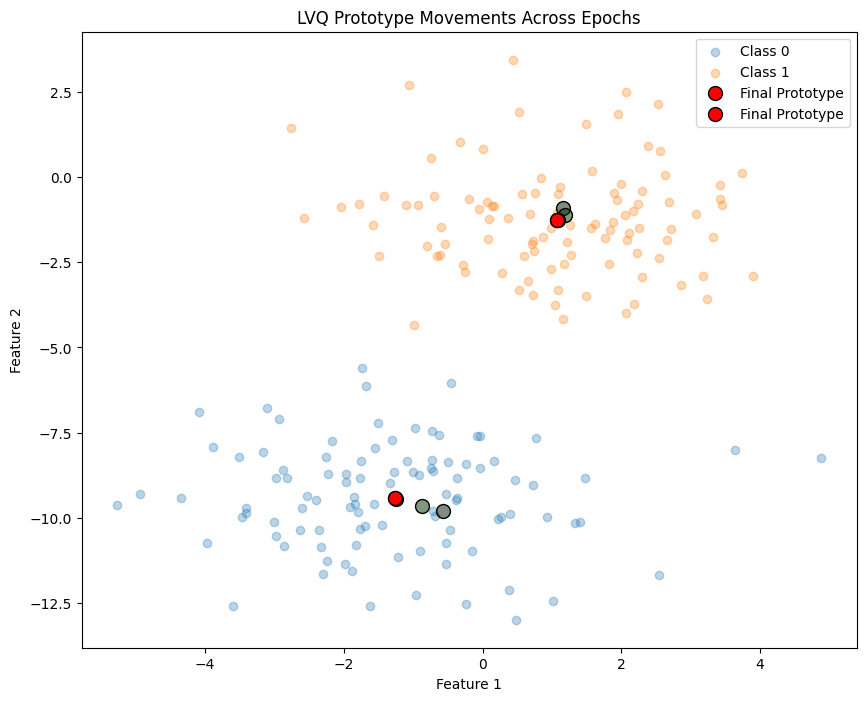

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib.colors import to_rgba

# Euclidean distance function
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)

# LVQ Training Function with Prototype Tracking
def lvq_train(X, y, prototypes, alpha, epochs, plot_intervals=5):
    history = []  # Track prototype positions over epochs for visualization

    for epoch in range(epochs):
        for i, x in enumerate(X):
            distances = np.array([euclidean_distance(x, p[1:]) for p in prototypes])
            winner_idx = np.argmin(distances)
            winner = prototypes[winner_idx]

            # Update prototypes based on classification
            if y[i] == winner[0]:  # correct class
                prototypes[winner_idx][1:] += alpha * (x - prototypes[winner_idx][1:])
            else:  # incorrect class
                prototypes[winner_idx][1:] -= alpha * (x - prototypes[winner_idx][1:])

        # Decay learning rate over time
        alpha *= (1 - epoch / epochs)

        # Save prototype positions at intervals for visualization
        if epoch % plot_intervals == 0 or epoch == epochs - 1:
            history.append(prototypes.copy())

    return prototypes, history

# Visualization Function to Plot Prototype Movements with Shading
def plot_lvq_progress(X, y, history):
    base_color = to_rgba('green', alpha=0.5)
    plt.figure(figsize=(10, 8))

    # Plot initial dataset points
    for label in np.unique(y):
        plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}', alpha=0.3)

    # Plot prototype movements over epochs with shading
    num_epochs = len(history)
    for epoch_idx, epoch_prototypes in enumerate(history):
        color_factor = (epoch_idx + 1) / num_epochs  # Scale color factor by epoch
        for proto in epoch_prototypes:
            # Gradually darken color for earlier prototypes and red for final
            if epoch_idx < num_epochs - 1:
                color = ((1 - color_factor) * base_color[0], color_factor * base_color[1],
                         color_factor * base_color[2], base_color[3])
                plt.scatter(proto[1], proto[2], s=100, color=color, edgecolor='k')
            else:
                plt.scatter(proto[1], proto[2], s=100, color='red', edgecolor='k', label='Final Prototype')

    plt.title("LVQ Prototype Movements Across Epochs")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.show()

# Example Usage
X, y = make_blobs(n_samples=200, centers=2, n_features=2, random_state=2, cluster_std=1.5)
prototypes = np.array([[0, 4.0, 2.0], [1, -2.0, -6.0]])  # Initial prototypes with class labels
alpha = 0.1
epochs = 20

# Train LVQ with prototype movement tracking
trained_prototypes, history = lvq_train(X, y, prototypes, alpha, epochs)
plot_lvq_progress(X, y, history)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train LVQ model
trained_prototypes, _ = lvq_train(X_train, y_train, prototypes, alpha, epochs)

# Make predictions on test set
def lvq_predict(X, prototypes):
    y_pred = []
    for x in X:
        distances = np.array([euclidean_distance(x, p[1:]) for p in prototypes])
        winner_idx = np.argmin(distances)
        y_pred.append(prototypes[winner_idx][0])
    return np.array(y_pred)

y_pred = lvq_predict(X_test, trained_prototypes)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 1.0
Confusion Matrix:
 [[20  0]
 [ 0 20]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00        20

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



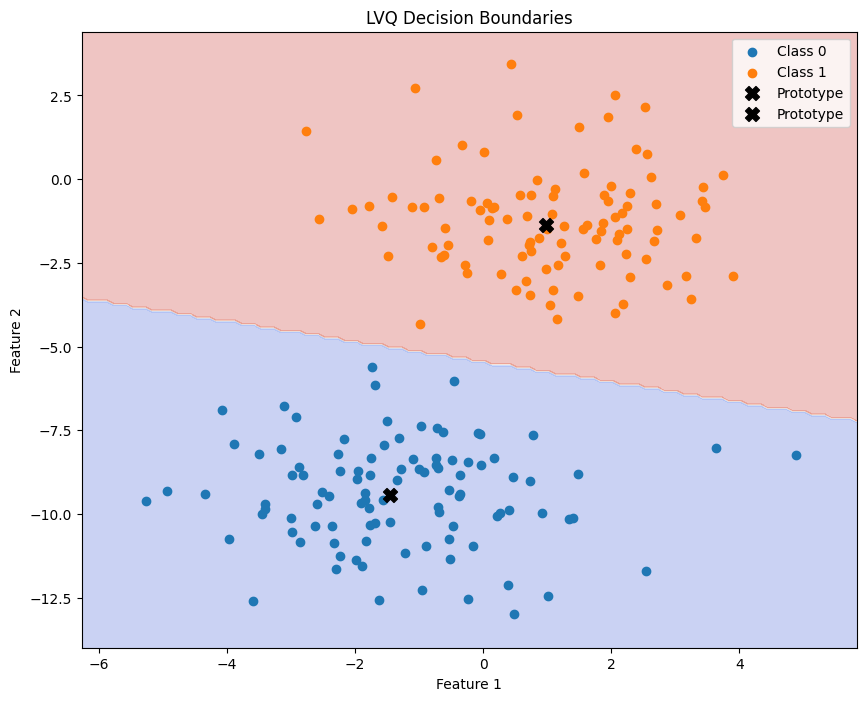

In [6]:
# Define bounds of the domain
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Define the meshgrid
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Flatten the grid to pass to the model
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_predictions = lvq_predict(grid_points, trained_prototypes)
grid_predictions = grid_predictions.reshape(xx.shape)


# Plot the decision boundaries
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, grid_predictions, alpha=0.3, cmap=plt.cm.coolwarm)

# Plot the training data
for label in np.unique(y):
    plt.scatter(X[y == label, 0], X[y == label, 1], label=f'Class {label}')

# Plot prototypes
for proto in trained_prototypes:
    plt.scatter(proto[1], proto[2], s=100, color='black', marker='X', label='Prototype')

plt.title("LVQ Decision Boundaries")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()
